In [1]:
cd ../src

c:\Users\fredl\Documents\Cours\M1 Androide\S2\ML\Projet\src


C:\Users\fredl\AppData\Roaming\Python\Python313\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from activation_func import *
from module import *
from loss import *
from optimizers import Optim
from mltools import *

In [3]:
X_train, y_train = load_usps("../data/USPS_train.txt")
X_test, y_test = load_usps("../data/USPS_train.txt")
# y_train = onehotencoder(y_train)
# y_test = onehotencoder(y_test)

encoder = [
    Linear(256, 64),
    TanH()
]
decoder = [
    Linear(64, 256),
    Sigmoid()
]
loss_fn = BCELoss()
autoencoder = Sequential(*(encoder + decoder))
batch_size = 64
learning_rate = 1e-3
num_epochs = 1000

100%|██████████| 1000/1000 [02:51<00:00,  5.83it/s]


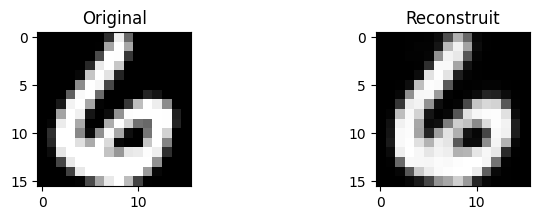

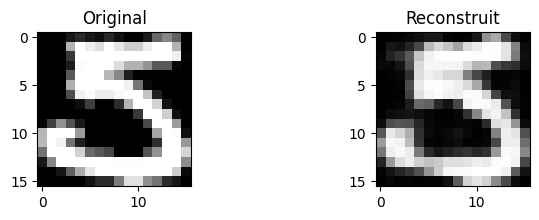

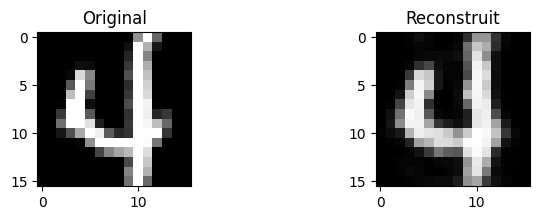

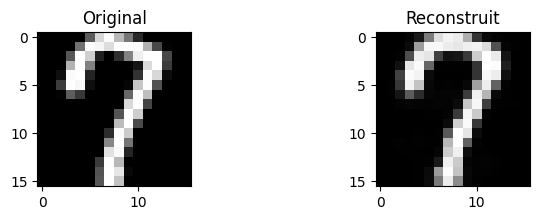

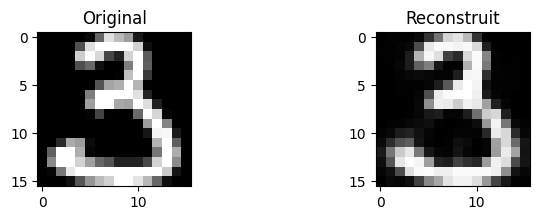

In [4]:
optimizer = Optim(autoencoder, loss_fn, learning_rate)
losses = optimizer.SGD(X_train, X_train, batch_size, num_epochs)

X_reconstructed = autoencoder.forward(X_test)

# Visualisation de quelques reconstructions
for i in range(5):
    plt.figure(figsize=(8, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(X_test[i].reshape(16, 16), cmap="gray")
    plt.title("Original")
    plt.subplot(1, 2, 2)
    plt.imshow(X_reconstructed[i].reshape(16, 16), cmap="gray")
    plt.title("Reconstruit")
    plt.show()

KMeans clustering done. Labels: [7 5 4 0 5 3 5 1 2 1]


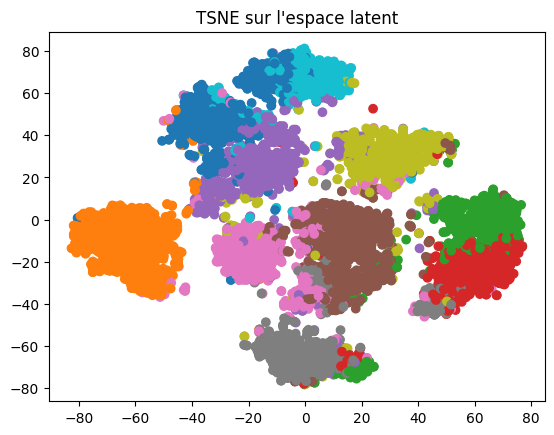

In [5]:
def get_latent_representation(X, model):
    out = X
    for layer in model.modules[:len(encoder)]:
        out = layer.forward(out)
    return out

latent = get_latent_representation(X_test, autoencoder)

kmeans = KMeans(n_clusters=10, random_state=0).fit(latent)
labels = kmeans.labels_
print("KMeans clustering done. Labels:", labels[:10])

tsne = TSNE(n_components=2, random_state=0)
latent_2d = tsne.fit_transform(latent)
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10')
plt.title("TSNE sur l'espace latent")
plt.show()

100%|██████████| 1000/1000 [08:12<00:00,  2.03it/s]  


NameError: name 'X' is not defined

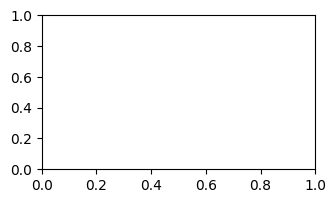

In [ ]:
X_noisy = X_test + np.random.normal(0, 0.1, X_test.shape)
X_noisy = np.clip(X_noisy, 0, 1)

optimizer2 = Optim(autoencoder, loss_fn, learning_rate)
losses2 = optimizer2.SGD(X_noisy, X_test, batch_size, num_epochs)

X_denoised = autoencoder.forward(X_noisy)

ValueError: cannot reshape array of size 255 into shape (16,16)

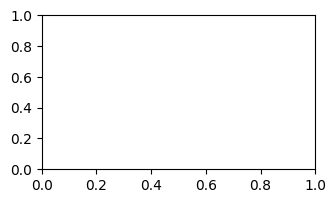

In [11]:
for i in range(5):
    plt.figure(figsize=(12, 2))
    plt.subplot(1, 3, 1)
    plt.imshow(X_test[i].reshape(16, 16), cmap="gray")
    plt.title("Original")
    plt.subplot(1, 3, 2)
    plt.imshow(X_noisy[i].reshape(16, 16), cmap="gray")
    plt.title("Bruitée")
    plt.subplot(1, 3, 3)
    plt.imshow(X_denoised[i].reshape(16, 16), cmap="gray")
    plt.title("Débruitée")
    plt.show()

In [ ]:
# Classification supervisée sur l'espace latent
X_test = load_usps("../data/USPS_test.txt")
X_test = X_test[0]
y_test = X_test[:, -1].astype(int)
X_test = X_test[:, :-1]
X_test = X_test / 255.0

X_train, X_val, y_train, y_val = train_test_split(X_train, labels, test_size=0.2, random_state=42)
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train_latent = get_latent_representation(X_train, autoencoder)
X_val_latent = get_latent_representation(X_val, autoencoder)
X_test_latent = get_latent_representation(X_test, autoencoder)
model = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
model.fit(X_train_latent, y_train)
y_pred = model.predict(X_val_latent)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy on validation set: {accuracy:.4f}")
y_test_pred = model.predict(X_test_latent)
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"Accuracy on test set: {accuracy_test:.4f}")
plt.scatter(X_test_latent[:, 0], X_test_latent[:, 1], c=y_test, cmap='tab10')
plt.title("Classification sur l'espace latent")
plt.show()

# Classification supervisée sur l'espace d'entrée
model = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy on validation set (input space): {accuracy:.4f}")
y_test_pred = model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"Accuracy on test set (input space): {accuracy_test:.4f}")
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='tab10')
plt.title("Classification sur l'espace d'entrée")
plt.show()